In [1]:
# kaggle notebook of this project is https://www.kaggle.com/code/rohit1313/project-1-phase-1
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # using this we can make the image of normal folder refer to normal output label and similary for pneumonia folder
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import math
import os
import pandas as pd

2024-03-12 12:49:29.592859: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 12:49:29.592991: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 12:49:29.877876: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.15.0


In [4]:
train_data_path = '../input/chest-xray-pneumonia/chest_xray/train'
filepaths = []
labels = []

folds = os.listdir(train_data_path)
for fold in folds:
    foldpath = os.path.join(train_data_path, fold)
    filelist = os.listdir(foldpath)
    
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)
        
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

df = pd.concat([FSeries, LSeries], axis=1)

In [5]:
df

,filepaths,label
0,../input/chest-xray-pneumonia/chest_xray/train...,PNEUMONIA
1,../input/chest-xray-pneumonia/chest_xray/train...,PNEUMONIA
2,../input/chest-xray-pneumonia/chest_xray/train...,PNEUMONIA
3,../input/chest-xray-pneumonia/chest_xray/train...,PNEUMONIA
4,../input/chest-xray-pneumonia/chest_xray/train...,PNEUMONIA
...,...,...
5211,../input/chest-xray-pneumonia/chest_xray/train...,NORMAL
5212,../input/chest-xray-pneumonia/chest_xray/train...,NORMAL
5213,../input/chest-xray-pneumonia/chest_xray/train...,NORMAL
5214,../input/chest-xray-pneumonia/chest_xray/train...,NORMAL


In [6]:
valid_data_dir = '../input/chest-xray-pneumonia/chest_xray/val'
filepaths = []
labels = []

folds = os.listdir(valid_data_dir)
for fold in folds:
    foldpath = os.path.join(valid_data_dir, fold)
    filelist = os.listdir(foldpath)
    
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)
        
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

valid = pd.concat([FSeries, LSeries], axis=1)

In [7]:
valid

,filepaths,label
0,../input/chest-xray-pneumonia/chest_xray/val/P...,PNEUMONIA
1,../input/chest-xray-pneumonia/chest_xray/val/P...,PNEUMONIA
2,../input/chest-xray-pneumonia/chest_xray/val/P...,PNEUMONIA
3,../input/chest-xray-pneumonia/chest_xray/val/P...,PNEUMONIA
4,../input/chest-xray-pneumonia/chest_xray/val/P...,PNEUMONIA
5,../input/chest-xray-pneumonia/chest_xray/val/P...,PNEUMONIA
6,../input/chest-xray-pneumonia/chest_xray/val/P...,PNEUMONIA
7,../input/chest-xray-pneumonia/chest_xray/val/P...,PNEUMONIA
8,../input/chest-xray-pneumonia/chest_xray/val/N...,NORMAL
9,../input/chest-xray-pneumonia/chest_xray/val/N...,NORMAL


In [8]:
test_data_dir = '../input/chest-xray-pneumonia/chest_xray/test'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)

for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)
        
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

test = pd.concat([FSeries, LSeries], axis=1)

In [9]:
test

,filepaths,label
0,../input/chest-xray-pneumonia/chest_xray/test/...,PNEUMONIA
1,../input/chest-xray-pneumonia/chest_xray/test/...,PNEUMONIA
2,../input/chest-xray-pneumonia/chest_xray/test/...,PNEUMONIA
3,../input/chest-xray-pneumonia/chest_xray/test/...,PNEUMONIA
4,../input/chest-xray-pneumonia/chest_xray/test/...,PNEUMONIA
...,...,...
619,../input/chest-xray-pneumonia/chest_xray/test/...,NORMAL
620,../input/chest-xray-pneumonia/chest_xray/test/...,NORMAL
621,../input/chest-xray-pneumonia/chest_xray/test/...,NORMAL
622,../input/chest-xray-pneumonia/chest_xray/test/...,NORMAL


In [10]:
from sklearn.model_selection import train_test_split
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=42)

In [11]:
# crobed image size
batch_size = 16 * strategy.num_replicas_in_sync
img_size = (180,180)

tr_gen = ImageDataGenerator(rescale = 1./255)
ts_gen = ImageDataGenerator(rescale = 1./255)
val_gen= ImageDataGenerator(rescale = 1./255)

train_dataset = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

val_dataset= val_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_dataset = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 4172 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.


In [12]:
# # To directly access the image from folder and take the folder name as the output label of data in that particular folder
# train = ImageDataGenerator(rescale = 1./255)
# test = ImageDataGenerator(rescale = 1./255)
# val = ImageDataGenerator(rescale = 1./255)

# train_dataset = train.flow_from_directory('../input/chest-xray-pneumonia/chest_xray/train/',
#                                           target_size = (180,180) , # we can change it later according to the need
#                                           batch_size = 16 * strategy.num_replicas_in_sync,
#                                           shuffle=True,
#                                           class_mode = 'binary' )

# test_dataset = test.flow_from_directory('../input/chest-xray-pneumonia/chest_xray/test/',
#                                           target_size = (180,180) , # we can change it later according to the need
#                                           batch_size = 16 * strategy.num_replicas_in_sync,
#                                           shuffle=True,
#                                           class_mode = 'binary' )

# val_dataset = val.flow_from_directory('../input/chest-xray-pneumonia/chest_xray/val/',
#                                           target_size = (180,180) , # we can change it later according to the need
#                                           batch_size =16 * strategy.num_replicas_in_sync,
#                                           shuffle=True,
#                                           class_mode = 'binary' )

In [13]:
# Assuming 'train_dataset' is your dataset object

# Get the shape of the data
data_shape = train_dataset.image_shape
print("Shape of data:", data_shape)


Shape of data: (180, 180, 3)


In [14]:
# Assuming the class names are 'normal' and 'pneumonia'
class_indices = train_dataset.class_indices

# Count the number of examples for each class
num_normal_examples = sum(1 for label in train_dataset.labels if label == class_indices['NORMAL'])
num_pneumonia_examples = sum(1 for label in train_dataset.labels if label == class_indices['PNEUMONIA'])

print("Number of normal examples:", num_normal_examples)
print("Number of pneumonia examples:", num_pneumonia_examples)

Number of normal examples: 1050
Number of pneumonia examples: 3122


In [15]:
train_dataset.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [16]:
# train_dataset.classes

In [17]:
# import matplotlib.pyplot as plt

# class_names = ['NORMAL', 'PNEUMONIA']

# # Retrieve a batch from the dataset
# images, labels = next(train_dataset)

# # Plot the images
# plt.figure(figsize=(70,70))
# for i in range(len(images)):
#     plt.subplot(10, 10, i + 1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     plt.imshow(images[i], cmap=plt.cm.binary)
#     plt.xlabel(class_names[int(labels[i])], fontsize=40)
# plt.show()


In [18]:
# Basic model
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(64,64, 3)),
#     tf.keras.layers.MaxPooling2D(2, 2),

#     # tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
#     # tf.keras.layers.MaxPooling2D(2,2)

#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(64, activation=tf.nn.relu),
#     tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
# ])

# Build the CNN

In [19]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters,(3,3), activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters,(3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D((2,2))
    ]
    )
    
    return block

In [20]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [21]:
def build_model():
    model = tf.keras.Sequential([
        
        tf.keras.layers.Conv2D(16,(3,3), activation='relu', padding='same',input_shape=(180,180, 3)),
        tf.keras.layers.Conv2D(16,(3,3), activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D((2,2)),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(2, activation='sigmoid') # 2 neural unit not 1
    ])
    
    return model

# Correct for data imbalance
We saw earlier in this notebook that the data was imbalanced, with more images classified as pneumonia than normal. We will correct for that in this following section.

In [22]:
initial_bias = np.log([num_pneumonia_examples/num_normal_examples])
initial_bias

array([1.08968366])

An initial bias of approximately 1.067 means that the model is inclined towards predicting the positive class (e.g., presence of pneumonia in medical images) when it starts training. This bias helps the model begin learning with a tendency towards one class over the other.

In [23]:
weight_for_0 = (1 / num_normal_examples)*(num_normal_examples+num_pneumonia_examples)/2.0 
weight_for_1 = (1 / num_pneumonia_examples)*(num_normal_examples+num_pneumonia_examples)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.99
Weight for class 1: 0.67


The value of weight_for_1 indicates the weight assigned to the positive class (e.g., images with pneumonia) during training, relative to the total number of pneumonia images and the total training image count.
In this context, the weight represents the importance or contribution of each class (e.g., images with pneumonia) during training. By adjusting the weights, you can address class imbalance and ensure that the model effectively learns from all classes, not just the majority class.

The weight for class 0 (Normal) is a lot higher than the weight for class 1 (Pneumonia). Since When there are fewer images of a particular class, assigning a higher weight to those images during training helps to balance the dataset. This weighting ensures that the model pays more attention to the minority class, thus preventing bias towards the majority class. This approach can improve the model's ability to learn from the imbalanced data and potentially enhance its performance on predicting the minority class.

Suppose if weight of class 0 will be less than we have to set higher weight to 0 then 1 so that model not get bias toward class 1 since have less weight and less images or data of class 0

set by yourself weight_for_0 and  weight_for_0
class_weight = {0: weight_for_0, 1: weight_for_1}

model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    class_weight=class_weight
)


# Train the model

Since there are only two possible labels for the image, we will be using the binary_crossentropy loss. When we fit the model, identify the class weights. Because we are using a TPU, training will be relatively quick.

For our metrics, we want to include precision and recall as they will provide use with a more informed picture of how good our model is. Accuracy tells us what fractions are the labels are correct. Since our data is not balanced, accuracy might give a skewed sense of a good model (i.e. a model that always predicts PNEUMONIA will be 74% accurate but is not a good model).

Precision is the number of true positives (TP) over the sum of TP and false positives (FP). It shows what fraction of labeled positives are actually correct.

Recall is the number of TP over the sum of TP and false negatves (FN). It shows what fraction of actual positives are correct.

In [24]:
with strategy.scope():
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.BinaryAccuracy(name='f1_score', threshold=0.5)
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [25]:
# EPOCHS =30  #100 # 25 
# history2 = model.fit(
#     train_dataset,
#     epochs=EPOCHS,
#     validation_data=val_dataset,
#     class_weight=class_weight,,
#     shuffle = False,
#     verbose= 1
# )

From exploring the data and the model, I noticed that the training for the model has a slow start. However, after 25 epochs, the model slowly starts to converge.

# Finetune the model
Finetuning is an art when it comes to Machine Learning, and there are many ways to adjust the model in efforts to improve it. Finetuning is beyond the scope of this notebook, but check out this article https://pyimagesearch.com/2019/06/03/fine-tuning-with-keras-and-deep-learning/ for more information.

For our purposes, we'll use Keras callbacks to further finetune our model. The checkpoint callback saves the best weights of the model, so next time we want to use the model, we do not have to spend time training it. The early stopping callback stops the training process when the model starts becoming stagnant, or even worse, when the model starts overfitting. Since we set restore_best_weights to True, the returned model at the end of the training process will be the model with the best weights (i.e. low loss and high accuracy).

In [26]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.keras",
                                                    save_best_only=True)

# early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
#                                                      restore_best_weights=True)

We also want to finetune our learning rate. Too high of a learning rate will cause the model to diverge. Too small of a learning rate will cause the model to be too slow. We implement the exponential learning rate scheduling method below.

In [27]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

Learning rate scheduler using exponential decay.
This scheduler gradually reduces the learning rate over epochs, which can help stabilize the training process and improve convergence.

In [28]:
EPOCHS =30  #100 # 25 
history2 = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    class_weight=class_weight,
#     callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
    callbacks=[checkpoint_cb, lr_scheduler],
    shuffle = False,
    verbose= 1
)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/261 ━━━━━━━━━━━━━━━━━━━━ 2:15:37 31s/step - accuracy: 0.5000 - f1_score: 0.5625 - loss: 0.5974 - precision: 0.5556 - recall: 0.6250

I0000 00:00:1710247835.406042      89 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710247835.437815      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.7537 - f1_score: 0.7442 - loss: 0.5150 - precision: 0.7451 - recall: 0.7430

W0000 00:00:1710247928.407258      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710247930.514587      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710247942.309662      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


261/261 ━━━━━━━━━━━━━━━━━━━━ 138s 412ms/step - accuracy: 0.7540 - f1_score: 0.7445 - loss: 0.5145 - precision: 0.7454 - recall: 0.7433 - val_accuracy: 0.8429 - val_f1_score: 0.8410 - val_loss: 0.4347 - val_precision: 0.8384 - val_recall: 0.8448 - learning_rate: 0.0100
Epoch 2/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 45s 173ms/step - accuracy: 0.8861 - f1_score: 0.8843 - loss: 0.2810 - precision: 0.8852 - recall: 0.8832 - val_accuracy: 0.2625 - val_f1_score: 0.2634 - val_loss: 5.1428 - val_precision: 0.2630 - val_recall: 0.2625 - learning_rate: 0.0089
Epoch 3/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 46s 175ms/step - accuracy: 0.9017 - f1_score: 0.9008 - loss: 0.2523 - precision: 0.9017 - recall: 0.8998 - val_accuracy: 0.9138 - val_f1_score: 0.9138 - val_loss: 0.2890 - val_precision: 0.9138 - val_recall: 0.9138 - learning_rate: 0.0079
Epoch 4/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 45s 174ms/step - accuracy: 0.9341 - f1_score: 0.9338 - loss: 0.1763 - precision: 0.9340 - recall: 0.9337 - val_accuracy: 0.9444 - val

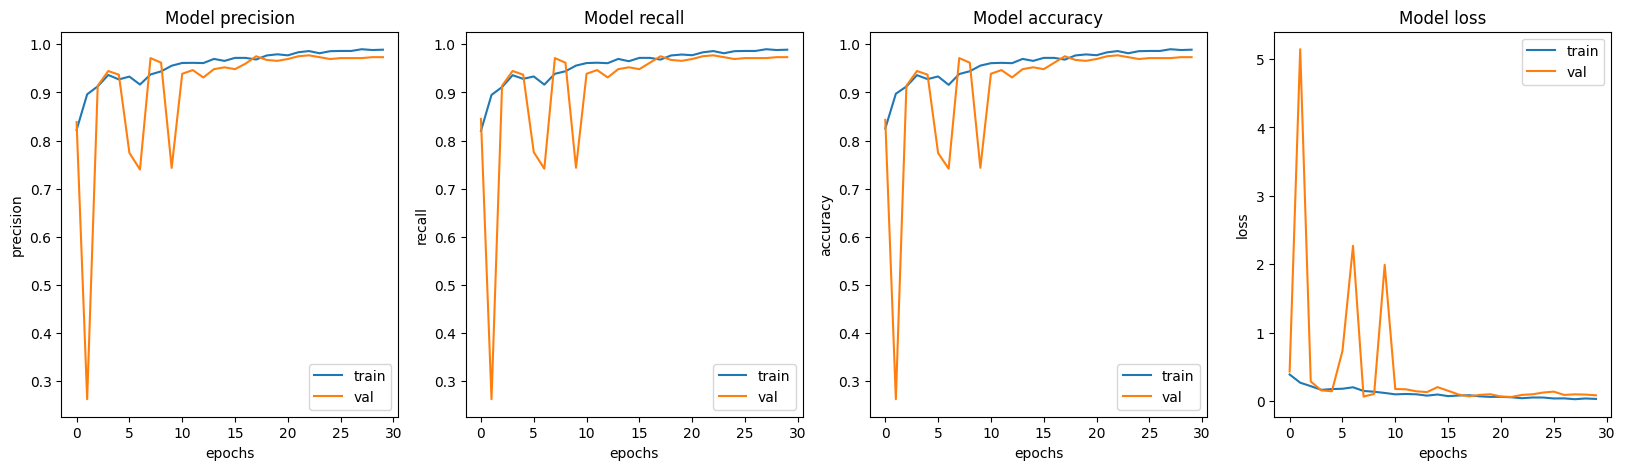

In [29]:
fig, ax = plt.subplots(1, 4, figsize=(20,5))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history2.history[met])
    ax[i].plot(history2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# Predict and evaluate results
Let's evaluate the model on our test data!

In [30]:
loss, acc, prec, rec, f1 = model.evaluate(test_dataset)

33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 334ms/step - accuracy: 0.9931 - f1_score: 0.9931 - loss: 0.0198 - precision: 0.9931 - recall: 0.9931


In [31]:
# Load the model saved by ModelCheckpoint
checkpoint_model = tf.keras.models.load_model("xray_model.keras")

# Evaluate the checkpoint model
loss, acc, prec, rec, f1= checkpoint_model.evaluate(test_dataset)


 1/33 ━━━━━━━━━━━━━━━━━━━━ 1:02 2s/step - accuracy: 1.0000 - f1_score: 1.0000 - loss: 0.0066 - precision: 1.0000 - recall: 1.0000

W0000 00:00:1710249262.493150      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - accuracy: 0.9961 - f1_score: 0.9961 - loss: 0.0186 - precision: 0.9961 - recall: 0.9961


W0000 00:00:1710249268.141924      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
